# Hackathon

In [210]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import clone as clone_model
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

In [211]:
columns_rename = {
 'tiempo': 'T',
 '% Solido  Bombeo concentrado_EB': 'EB%', 
 'Presión de Descarga_EB_1': 'EB1',
 'Presión de Descarga_EB_2': 'EB2',
 'Presion_Estación de Valvulas_EV1_1': 'EV1_1',
 'Presión estación de valvulas 2_EV2_1': 'EV2_1',
 'Presion_Estación de Valvulas_EV1_2': 'EV1_2',
 'Presión estación de valvulas 2_EV2_2': 'EV2_2',
 'Presión_SM-1': 'SM1',
 'Presión_SM-2': 'SM2',
 'Presión_SM-3': 'SM3',
 'Presión_SM-4': 'SM4',
 'Porcentaje de Solido Alimentación Espesador': 'EDT%',
 'Presión_EDT_1': 'EDT1',
 'Presión_EDT_2': 'EDT2',
 'Presión_EDT_3': 'EDT3'
}

# Solución final

In [194]:
final_data = pd.read_excel('Data_test_hakcathon_CEN.xlsx')
train_data = pd.read_excel('Hack_concentraducto_v01.xlsx', sheet_name='Data_Hackathon')

In [195]:
final_data.rename(columns=columns_rename, inplace=True)
train_data.rename(columns=columns_rename, inplace=True)

In [196]:
models = dict()
pretrained_models = dict()

## Modelo SM1

In [197]:
sm1_model = XGBRegressor(random_state=42, n_estimators=175, learning_rate=0.302, reg_lambda=1, reg_alpha=0.5)
models['SM1'] = clone_model(sm1_model)

In [198]:
sm1_model.fit(train_data[['EB%','EB1','EB2','SM2','EV1_1']], train_data['SM1'])
pretrained_models['SM1'] = sm1_model

## Modelo SM2

In [199]:
sm2_model = make_pipeline(PolynomialFeatures(degree=4),  LinearRegression())
models['SM2'] = clone_model(sm2_model)

In [200]:
sm2_model.fit(train_data[['EV1_1', 'EV1_2']], train_data['SM2'])
pretrained_models['SM2'] = sm2_model

## Modelo SM3

In [201]:
sm3_model = XGBRegressor(random_state=42, n_estimators=175, learning_rate=0.302, reg_lambda=1, reg_alpha=0.5)
models['SM3'] = clone_model(sm3_model)

In [202]:
sm3_model.fit(train_data[['SM2', 'EV1_2', 'EV2_1', 'EV2_2']], train_data['SM3'])
pretrained_models['SM3'] = sm3_model

## Modelo SM4

In [203]:
sm4_model = XGBRegressor(random_state=42, n_estimators=175, learning_rate=0.302, reg_lambda=1, reg_alpha=0.5)
models['SM4'] = clone_model(sm4_model)

In [204]:
sm4_model.fit(train_data[['EV2_1','EV2_2', 'EDT%', 'EDT1']], train_data['SM4'])
pretrained_models['SM4'] = sm4_model

## Predicción de datos faltantes

### SM1

In [205]:
y_1 = final_data['SM1']
y_1_targets = y_1.isna()
X_1 = final_data[y_1_targets][['EB%','EB1','EB2','SM2','EV1_1']]
y_1_pred = pretrained_models['SM1'].predict(X_1)
final_data.loc[y_1_targets, 'SM1'] = y_1_pred

### SM2

In [206]:
y_2 = final_data['SM2']
y_2_targets = y_2.isna()
X_2 = final_data[y_2_targets][['EV1_1', 'EV1_2']]
y_2_pred = pretrained_models['SM2'].predict(X_2)
final_data.loc[y_2_targets, 'SM2'] = y_2_pred

### SM3

In [207]:
y_3 = final_data['SM3']
y_3_targets = y_3.isna()
X_3 = final_data[y_3_targets][['SM2', 'EV1_2', 'EV2_1', 'EV2_2']]
y_3_pred = pretrained_models['SM3'].predict(X_3)
final_data.loc[y_3_targets, 'SM3'] = y_3_pred

### SM4

In [208]:
y_4 = final_data['SM4']
y_4_targets = y_4.isna()
X_4 = final_data[y_4_targets][['EV2_1','EV2_2', 'EDT%', 'EDT1']]
y_4_pred = pretrained_models['SM4'].predict(X_4)
final_data.loc[y_4_targets, 'SM4'] = y_4_pred

## Exportado de datos finales

In [212]:
final_data.to_excel('Data_test_hackathon_CEN_final_Team_ARCA.xlsx', index=False)

PermissionError: [Errno 13] Permission denied: 'Data_test_hackathon_CEN_final_Team_ARCA.xlsx'

# Trabajo de desarrollo y selección de modelos

In [ ]:
data = pd.read_excel('Hack_concentraducto_v01.xlsx', sheet_name='Data_Hackathon')
df1 = data.copy()
df1.head()

In [ ]:
df1.isnull().sum()

In [213]:
mean_concentrated = df1["% Solido  Bombeo concentrado_EB"].mean()
mean_concentrated

43.04818888272726

In [214]:
min_concentrated = df1["Presión de Descarga_EB_1"].min()
min_concentrated

-7.87132453918457

# Preprocesamiento
## Conversión de datos

In [215]:
df2 = data.copy()
df2.rename(columns=columns_rename, inplace=True)

### Conversión de presiones

In [216]:
conversion = 6.89476

df2['EB1'] = df2['EB1'].apply(lambda x: x * conversion)
df2['EB2'] = df2['EB2'].apply(lambda x: x * conversion)

### Normalización de datos
El resultado de esta etapa fue utilizado para el análisis exploratorio de datos, pero no se considero esta transformación para los modelos finales, ya que en los modelos escogidos, no generaban diferencias, y se quiso evitar transformaciones innecesesarias entre las medidas (puesto que, si se normalizaban los datos, se debería hacer la transformación inversa para obtener los valores reales).

In [217]:
excluded_columns = ['T']
normalize_columns = [col for col in df2.columns if col not in excluded_columns]

scaler = StandardScaler()

df_normalized = pd.DataFrame(scaler.fit_transform(df2[normalize_columns]), columns=normalize_columns)
df_normalized = pd.concat([df2[excluded_columns], df_normalized], axis=1)


# Visualización de datos

array([[<Axes: xlabel='EB%', ylabel='EB%'>,
        <Axes: xlabel='EB1', ylabel='EB%'>,
        <Axes: xlabel='EB2', ylabel='EB%'>,
        <Axes: xlabel='EV1_1', ylabel='EB%'>,
        <Axes: xlabel='EV1_2', ylabel='EB%'>,
        <Axes: xlabel='SM1', ylabel='EB%'>,
        <Axes: xlabel='SM2', ylabel='EB%'>,
        <Axes: xlabel='EV2_1', ylabel='EB%'>,
        <Axes: xlabel='EV2_2', ylabel='EB%'>,
        <Axes: xlabel='EDT%', ylabel='EB%'>,
        <Axes: xlabel='EDT1', ylabel='EB%'>,
        <Axes: xlabel='EDT2', ylabel='EB%'>,
        <Axes: xlabel='EDT3', ylabel='EB%'>,
        <Axes: xlabel='SM3', ylabel='EB%'>,
        <Axes: xlabel='SM4', ylabel='EB%'>],
       [<Axes: xlabel='EB%', ylabel='EB1'>,
        <Axes: xlabel='EB1', ylabel='EB1'>,
        <Axes: xlabel='EB2', ylabel='EB1'>,
        <Axes: xlabel='EV1_1', ylabel='EB1'>,
        <Axes: xlabel='EV1_2', ylabel='EB1'>,
        <Axes: xlabel='SM1', ylabel='EB1'>,
        <Axes: xlabel='SM2', ylabel='EB1'>,
        <Axes: 

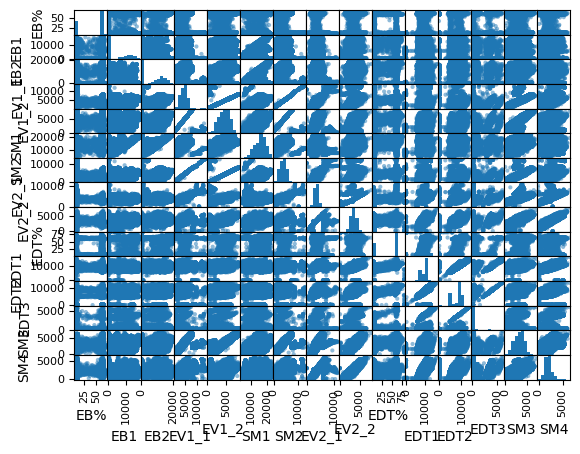

In [148]:
pd.plotting.scatter_matrix(df2)

In [ ]:
pd.plotting.scatter_matrix(df_normalized)

In [ ]:
feats = df2.columns.difference(['T'])
for feat in df2.columns.difference(['T']):
 plt.plot(df2['T'], df2[feat])
plt.xlabel('T')
plt.show()

In [ ]:
for feat in feats:
 plt.plot(df_normalized['T'], df_normalized[feat])
plt.xlabel('T')
plt.show()

### Correlación entre SM2 y EV2
Analizando el conjunto de datos, se encontró que, en casos donde la presión de SM2 cambia entre dos tuplas de manera drástica, el cambio se propaga de manera instantánea a la presión de EV2. Esto se puede observar en el siguiente gráfico:

In [ ]:
plt.scatter(df_normalized['SM2'], df_normalized['EV1_1'], xlabel='SM2', ylabel='EV1_1')

In [ ]:
plt.scatter(df_normalized['SM4'], df_normalized['EV2_2'])

In [ ]:
plt.scatter(df_normalized['SM4'], df_normalized['EDT1'])

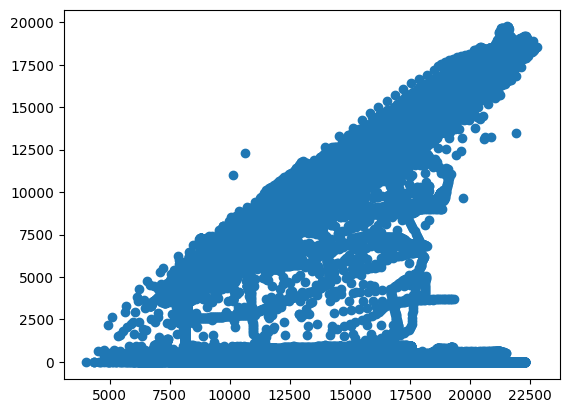

In [85]:
plt.scatter(df_normalized['SM1'], df_normalized['EB2'])


In [ ]:
plt.scatter(df_normalized['SM1'], df_normalized['SM2'])

In [ ]:
plt.scatter(df_normalized['SM3'], df_normalized['EV2_1'])

In [ ]:
plt.scatter(df_normalized['SM3'], df_normalized['EV1_2'])

# Modelo Lineal

## Predicción SM1

In [219]:
X_1 = df2[['EB%','EB1','EB2','SM2','EV1_1']]
y_1 = df2['SM1']
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, random_state=42, test_size=0.4)

### Regresión Linear

In [220]:
sm1 = LinearRegression()
sm1.fit(X_train, y_train)
y_pred = sm1.predict(X_test)
r2_1 = r2_score(y_test, y_pred)
mae_1 = mean_absolute_error(y_test, y_pred)
print(f'SM1: R2 = {r2_1}, MAE = {mae_1}')

SM1: R2 = 0.7502695851396284, MAE = 1126.1248977259718


Observaciones:
Mayor puntuación, con un 30% de datos asignados para validación, con todos los datos de presión en [kPa]

### Regresión Linear Polinomial

In [221]:
poly = PolynomialFeatures(degree=3)
linear = LinearRegression()
sm1 = make_pipeline(poly, linear)
sm1.fit(X_train, y_train)
y_pred = sm1.predict(X_test)
r2_1 = r2_score(y_test, y_pred)
mae_1 = mean_absolute_error(y_test, y_pred)
print(f'SM1: R2 = {r2_1}, MAE = {mae_1}')

SM1: R2 = 0.9528889045400045, MAE = 510.2336206442199


### Regresión Lasso

In [222]:
sm1 = LassoCV(max_iter=5000)
sm1.fit(X_train, y_train)
y_pred = sm1.predict(X_test)
r2_1 = r2_score(y_test, y_pred)
mae_1 = mean_absolute_error(y_test, y_pred)
print(f'SM1: R2 = {r2_1}, MAE = {mae_1}')

SM1: R2 = 0.7351899565507516, MAE = 1180.3034072051905


En primer intento, se tuvo menor puntaje y problemas de convergencia.
Se aumenta número de iteraciones y se obtiene mayor demora, manteniendo puntaje.

### Elastic Net

In [223]:
sm1 = ElasticNetCV()
sm1.fit(X_train, y_train)
y_pred = sm1.predict(X_test)
r2_1 = r2_score(y_test, y_pred)
mae_1 = mean_absolute_error(y_test, y_pred)
print(f'SM1: R2 = {r2_1}, MAE = {mae_1}')

SM1: R2 = 0.7091620396776757, MAE = 1248.6822513313455


### SGD

In [224]:
sm1 = SGDRegressor()
sm1.fit(X_train, y_train)
y_pred = sm1.predict(X_test)
r2_1 = r2_score(y_test, y_pred)
mae_1 = mean_absolute_error(y_test, y_pred)
print(f'SM1: R2 = {r2_1}, MAE = {mae_1}')

SM1: R2 = -1.3256787269807711e+25, MAE = 8885736339027663.0


### XGBoost

In [225]:
sm1 = XGBRegressor(random_state=42, n_estimators=175, learning_rate=0.302, reg_lambda=1, reg_alpha=0.5)
sm1.fit(X_train, y_train)
y_pred = sm1.predict(X_test)
r2_1 = r2_score(y_test, y_pred)
mae_1 = mean_absolute_error(y_test, y_pred)
print(f'SM1: R2 = {r2_1}, MAE = {mae_1}')

SM1: R2 = 0.9814259150023139, MAE = 277.32857523480305


### Random Forest

Observaciones:
Entrenamiento lento, fuera de plazo máximo. Descartado.

## Predicción SM2
Luego del análisis explorativo, se encontró una alta correlación entre las mediciones de SM2 y EV1, por lo cual se escogen sus sensores como únicas entradas del modelo.

In [226]:
X_2 = df2[['EV1_1', 'EV1_2']]
y_2 = df2['SM2']
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, random_state=42, test_size=0.4)

### Regresión Linear

In [227]:
sm2 = LinearRegression()
sm2.fit(X_2_train, y_2_train)
y_2_pred = sm2.predict(X_2_test)
r2_2 = r2_score(y_2_test, y_2_pred)
mae_2 = mean_absolute_error(y_2_test, y_2_pred)
print(f'SM2: R2 = {r2_2}, MAE = {mae_2}')

SM2: R2 = 0.9951879786633565, MAE = 92.02318713802477


Observaciones:
Evaluando indivdualmente, al considerar solo la medición de entrada de EV1, se obtiene una puntuación de R2 = 0.9948631933284161, MAE = 0.061770157769054965; considerando entrada y salida de EV1, se obtiene R2 = 0.9951739335689458, MAE = 0.06143409021178661.

### Regresión Linear Polinomial

In [228]:
poly = PolynomialFeatures(degree=4)
linear = LinearRegression()
sm2 = make_pipeline(poly, linear)
sm2.fit(X_2_train, y_2_train)
y_2_pred = sm2.predict(X_2_test)
r2_2 = r2_score(y_2_test, y_2_pred)
mae_2 = mean_absolute_error(y_2_test, y_2_pred)
print(f'SM2: R2 = {r2_2}, MAE = {mae_2}')

SM2: R2 = 0.9957065089865466, MAE = 85.67681389206547


### Regresión Lasso

In [229]:
sm2 = LassoCV()
sm2.fit(X_2_train, y_2_train)
y_2_pred = sm2.predict(X_2_test)
r2_2 = r2_score(y_2_test, y_2_pred)
mae_2 = mean_absolute_error(y_2_test, y_2_pred)
print(f'SM2: R2 = {r2_2}, MAE = {mae_2}')

SM2: R2 = 0.9951883007623118, MAE = 91.88570648924468


### Elastic Net

In [230]:
sm2 = ElasticNetCV()
sm2.fit(X_2_train, y_2_train)
y_2_pred = sm2.predict(X_2_test)
r2_2 = r2_score(y_2_test, y_2_pred)
mae_2 = mean_absolute_error(y_2_test, y_2_pred)
print(f'SM2: R2 = {r2_2}, MAE = {mae_2}')

SM2: R2 = 0.9951855931811426, MAE = 92.00102721888321


### SGD

In [231]:
sm2 = SGDRegressor()
sm2.fit(X_2_train, y_2_train)
y_2_pred = sm2.predict(X_2_test)
r2_2 = r2_score(y_2_test, y_2_pred)
mae_2 = mean_absolute_error(y_2_test, y_2_pred)
print(f'SM2: R2 = {r2_2}, MAE = {mae_2}')

SM2: R2 = -1.1152976260355227e+24, MAE = 1506317266988942.5


### XGBoost

In [232]:
sm2 = XGBRegressor(random_state=42)
sm2.fit(X_2_train, y_2_train)
y_2_pred = sm2.predict(X_2_test)
r2_2 = r2_score(y_2_test, y_2_pred)
mae_2 = mean_absolute_error(y_2_test, y_2_pred)
print(f'SM2: R2 = {r2_2}, MAE = {mae_2}')

SM2: R2 = 0.9950427877486195, MAE = 86.92988964874716


## Predicción SM3
Luego del análisis explorativo, se encontró una correlación entre las mediciones de SM3 y EV1, y entre SM3 y EB2.

In [233]:
X_3 = df2[['SM2', 'EV1_2', 'EV2_1', 'EV2_2']]
y_3 = df2['SM3']
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, random_state=42, test_size=0.4)

### Regresión Linear

In [234]:
sm3 = LinearRegression()
sm3.fit(X_3_train, y_3_train)
y_3_pred = sm3.predict(X_3_test) 
r2_3 = r2_score(y_3_test, y_3_pred)
mae_3 = mean_absolute_error(y_3_test, y_3_pred)
print(f'SM3: R2 = {r2_3}, MAE = {mae_3}')

SM3: R2 = 0.8663263317109933, MAE = 290.06154586049433


Observaciones:
Evaluando indivdualmente, al considerar solo la medición de salida de EV1, se obtiene una puntuación de R2 = 0.757428290149249, MAE = 0.36624686002811024; y considerando solo la medición de entrada de EV2, se obtiene R2 = 0.5894141038841055, MAE = 0.44782809908607935.
Considerando ambas mediciones, se obtiene R2 = 0.8643364789365919, MAE = 0.27408716724892734

### Regresión Linear Polinomial

In [248]:
poly = PolynomialFeatures(degree=4)
linear = LinearRegression()
sm3 = make_pipeline(poly, linear)
sm3.fit(X_3_train, y_3_train)
y_3_pred = sm3.predict(X_3_test)
r2_3 = r2_score(y_3_test, y_3_pred)
mae_3 = mean_absolute_error(y_3_test, y_3_pred)
print(f'SM3: R2 = {r2_3}, MAE = {mae_3}')

SM3: R2 = 0.9134248735712982, MAE = 212.9049616762026


### Regresión Lasso

In [236]:
sm3 = LassoCV()
sm3.fit(X_3_train, y_3_train)
y_3_pred = sm3.predict(X_3_test)
r2_3 = r2_score(y_3_test, y_3_pred)
mae_3 = mean_absolute_error(y_3_test, y_3_pred)
print(f'SM3: R2 = {r2_3}, MAE = {mae_3}')

SM3: R2 = 0.8663192489145828, MAE = 290.0359064972062


### Elastic Net

In [237]:
sm3 = ElasticNetCV()
sm3.fit(X_3_train, y_3_train)
y_3_pred = sm3.predict(X_3_test)
r2_3 = r2_score(y_3_test, y_3_pred)
mae_3 = mean_absolute_error(y_3_test, y_3_pred)
print(f'SM3: R2 = {r2_3}, MAE = {mae_3}')

SM3: R2 = 0.8663014514728018, MAE = 290.00771589320857


### SGD

In [238]:
sm3 = SGDRegressor()
sm3.fit(X_3_train, y_3_train)
y_3_pred = sm3.predict(X_3_test)
r2_3 = r2_score(y_3_test, y_3_pred)
mae_3 = mean_absolute_error(y_3_test, y_3_pred)
print(f'SM3: R2 = {r2_3}, MAE = {mae_3}')

SM3: R2 = -2.1508691535351057e+25, MAE = 4887222941849783.0


### XGBoost

In [239]:
sm3 = XGBRegressor(random_state=42, n_estimators=175, learning_rate=0.302, reg_lambda=1, reg_alpha=0.5)
sm3.fit(X_3_train, y_3_train)
y_3_pred = sm3.predict(X_3_test)
r2_3 = r2_score(y_3_test, y_3_pred)
mae_3 = mean_absolute_error(y_3_test, y_3_pred)
print(f'SM3: R2 = {r2_3}, MAE = {mae_3}')

SM3: R2 = 0.9503469215649503, MAE = 144.6383184903375


## Predicción SM4
Luego del análisis explorativo, se encontró una correlación entre las mediciones de SM4 y EV2, y entre SM4 y EDT1.

In [240]:
X_4 = df2[['EV2_1','EV2_2', 'EDT%', 'EDT1']] 
y_4 = df2['SM4']
X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X_4, y_4, random_state=42, test_size=0.4)

### Regresión Linear

In [241]:
sm4 = LinearRegression()
sm4.fit(X_4_train, y_4_train)
y_4_pred = sm4.predict(X_4_test)
r2_4 = r2_score(y_4_test, y_4_pred)
mae_4 = mean_absolute_error(y_4_test, y_4_pred)
print(f'SM4: R2 = {r2_4}, MAE = {mae_4}')

SM4: R2 = 0.8760905570138721, MAE = 158.73424488737462


### Regresión Lineal Polinomial

In [242]:
poly = PolynomialFeatures(degree=4)
linear = LinearRegression()
sm4 = make_pipeline(poly, linear)
sm4.fit(X_4_train, y_4_train)
y_4_pred = sm4.predict(X_4_test)
r2_4 = r2_score(y_4_test, y_4_pred)
mae_4 = mean_absolute_error(y_4_test, y_4_pred)
print(f'SM4: R2 = {r2_4}, MAE = {mae_4}')

SM4: R2 = 0.9277962653478198, MAE = 87.08924855419416


### Regresión Lasso

In [243]:
sm4 = LassoCV()
sm4.fit(X_4_train, y_4_train)
y_4_pred = sm4.predict(X_4_test)
r2_4 = r2_score(y_4_test, y_4_pred)
mae_4 = mean_absolute_error(y_4_test, y_4_pred)
print(f'SM4: R2 = {r2_4}, MAE = {mae_4}')

SM4: R2 = 0.8743440421327682, MAE = 166.47632528620463


### Elastic Net

In [244]:
sm4 = ElasticNetCV()
sm4.fit(X_4_train, y_4_train)
y_4_pred = sm4.predict(X_4_test)
r2_4 = r2_score(y_4_test, y_4_pred)
mae_4 = mean_absolute_error(y_4_test, y_4_pred)
print(f'SM4: R2 = {r2_4}, MAE = {mae_4}')

SM4: R2 = 0.8337612634590793, MAE = 212.13140705593008


### SGD

In [245]:
sm4 = SGDRegressor()
sm4.fit(X_4_train, y_4_train)
y_4_pred = sm4.predict(X_4_test)
r2_4 = r2_score(y_4_test, y_4_pred)
mae_4 = mean_absolute_error(y_4_test, y_4_pred)
print(f'SM4: R2 = {r2_4}, MAE = {mae_4}')

SM4: R2 = -2.902078293159654e+25, MAE = 3682519252781018.0


### XGBoost

In [246]:
sm4 = XGBRegressor(random_state=42, n_estimators=175, learning_rate=0.302, reg_lambda=1, reg_alpha=0.5)
sm4.fit(X_4_train, y_4_train)
y_4_pred = sm4.predict(X_4_test)
r2_4 = r2_score(y_4_test, y_4_pred)
mae_4 = mean_absolute_error(y_4_test, y_4_pred)
print(f'SM4: R2 = {r2_4}, MAE = {mae_4}')

SM4: R2 = 0.9657182823470207, MAE = 57.788102225919836
